In [11]:
import os
import sys
import re
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import LongTensor

In [12]:
DATA_PATH = "/home/xiaolong/Data/Dataset/lane-detection-for-carla-driving-simulator"

train_data_path_x = os.path.join(DATA_PATH, 'train')
train_data_path_y = os.path.join(DATA_PATH, 'train_label')

valid_data_path_x = os.path.join(DATA_PATH, 'val')
valid_data_path_y = os.path.join(DATA_PATH, 'val_label')

In [13]:
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [43]:
class CarlaLaneDataset(Dataset):
    
    CLASSES = ['background', 'left_marker', 'right_marker']
    
    def __init__(self, images_path, masks_path, classes=None, augmentation=None, preprocessing=None):
        self.image_name_list = os.listdir(images_path)
        self.images = [os.path.join(images_path, image_name) for image_name in self.image_name_list]
        get_label_name = lambda fn: re.sub(".png", "_label.png", fn)
        self.masks = [os.path.join(masks_path, get_label_name(image_name)) for image_name  in self.image_name_list]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):
        image = cv2.imread(self.images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[i], 0)
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, LongTensor(mask)
    
    def __len__(self):
        return len(self.images)
        

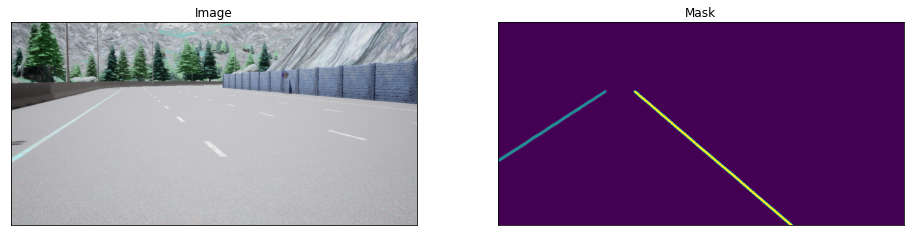

In [65]:
dataset = CarlaLaneDataset(train_data_path_x, train_data_path_y, classes=CarlaLaneDataset.CLASSES)
image, mask= dataset[random.randint(0, dataset.__len__())]
visualize(image=image, mask=mask)

In [45]:
import albumentations as albu

In [46]:
def get_training_augmentation():
    train_transform = [
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0., shift_limit=0.1, p=1, border_mode=0),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.OneOf([
            albu.CLAHE(p=1),
            albu.RandomBrightness(p=1),
            albu.RandomGamma(p=1)],
            p=0.6),
        albu.OneOf([
            albu.IAASharpen(p=1),
            albu.Blur(blur_limit=3, p=1),
            albu.MotionBlur(blur_limit=3, p=1)],
            p=0.6),
        albu.OneOf([
            albu.RandomContrast(p=1),
            albu.HueSaturationValue(p=1)],
            p=0.6)]
    
    return albu.Compose(train_transform)


def get_validation_augmentation():
    
    return None


def to_tensor(x, **kwargs):
    
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):   
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    
    return albu.Compose(_transform)

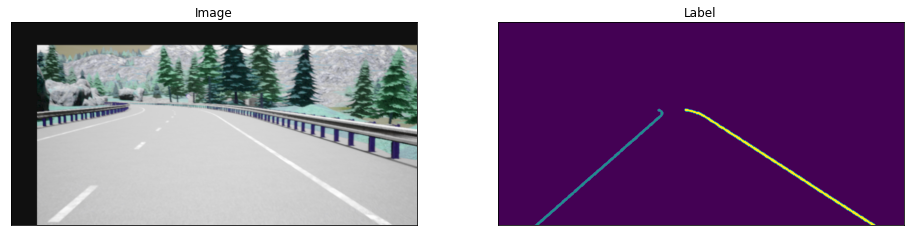

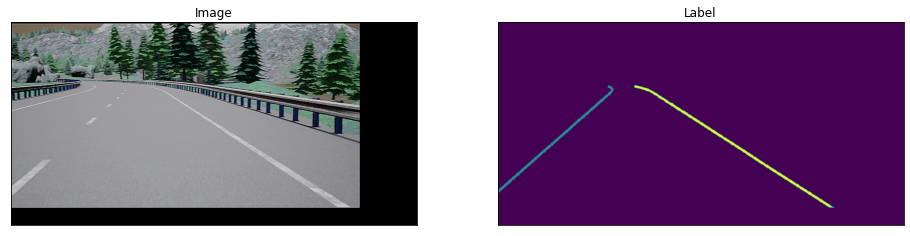

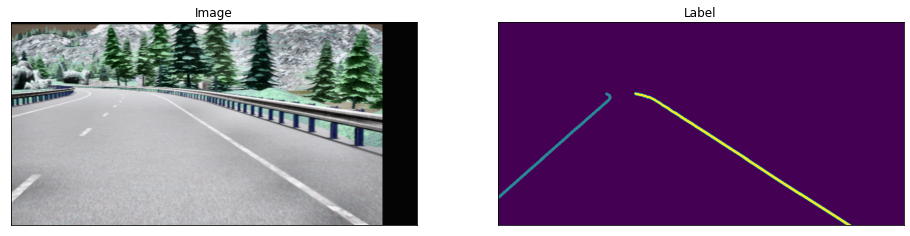

In [67]:
augmented_dataset = CarlaLaneDataset(
    train_data_path_x, 
    train_data_path_y, 
    augmentation=get_training_augmentation(), 
    classes=CarlaLaneDataset.CLASSES,
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, label=mask)

In [68]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [69]:
loss_string = "multi_dice_loss"

ENCODER = "efficientnet-b0"
ENCODER_WEIGHTS = "imagenet"
ACTIVATION = "softmax2d"
DEVICE = "cuda"

model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CarlaLaneDataset.CLASSES),
    activation=ACTIVATION
#     encoder_depth=4
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [70]:
train_dataset = CarlaLaneDataset(
    train_data_path_x,
    train_data_path_y,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CarlaLaneDataset.CLASSES
)

valid_dataset = CarlaLaneDataset(
    valid_data_path_x,
    valid_data_path_y,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CarlaLaneDataset.CLASSES
)

In [71]:
batch_size_train = 4
batch_size_valid = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size_valid, shuffle=False)

In [72]:
from segmentation_models_pytorch.utils import base
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import Accuracy

label_left = CarlaLaneDataset.CLASSES.index('left_marker')
label_right = CarlaLaneDataset.CLASSES.index('right_marker')

class MultiDiceLoss(base.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.BinaryDiceLossLeft = DiceLoss()
        self.BinaryDiceLossRight = DiceLoss()
        
    def forward(self, y_pr, y_gt):
        left_gt = (y_gt==label_left)
        right_gt = (y_gt==label_right)
        loss_left = self.BinaryDiceLossLeft.forward(y_pr[:,label_left,:,:] , left_gt)
        loss_right = self.BinaryDiceLossRight.forward(y_pr[:,label_right,:,:] , right_gt)
        
        return (loss_left + loss_right) * 0.5

In [73]:
metrics = []

loss = MultiDiceLoss()

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=1e-4)])

In [74]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [75]:
best_loss = 1e10

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if best_loss > valid_logs[loss_string]:
        best_loss = valid_logs[loss_string]
        torch.save(model, './best_model_{}.pth'.format(loss_string))
        print('Model saved!')
        
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 33/33 [00:08<00:00,  4.06it/s, multi_dice_loss - 0.2111]
Model saved!

Epoch: 1
train:   1%|          | 6/769 [00:03<07:48,  1.63it/s, multi_dice_loss - 0.1894]


KeyboardInterrupt: 